In [2]:
import sys, os, io, json, numpy as np, random
#from sklearn.metrics import roc_auc_score
import xgboost as xgb
import tensorflow as tf
from split import split_graph, split_interface, make_split
import graphviz
from sklearn import metrics

In [3]:
pool = np.load('../prepare_dataset/pool_00.npz')
features_bool, f_time, label = (pool[name] for name in ['features', 'f_time', 'label'])

In [4]:
np.random.seed(42)

In [5]:
features = np.random.normal(loc=features_bool*1.0, scale=1.0)

In [6]:
#features_swap = features.copy()
#features_swap[:,0],features_swap[:,7] = features_swap[:,7],features_swap[:,0]
features_swap = np.concatenate([features[:,7:8], features[:,1:7], features[:,0:1], features[:,8:]], axis=1)

In [7]:
%%time
make_split(np.zeros(label.shape), features, label)

CPU times: user 553 ms, sys: 671 ms, total: 1.22 s
Wall time: 2.03 s


{'avg_current_loss': array([0.6931475], dtype=float32),
 'best_avg_loss': 0.6108208,
 'best_delta_down': 0.4,
 'best_delta_up': -0.8033454,
 'best_feature_index': 4,
 'best_index': 299988,
 'best_loss': 183246.23,
 'current_loss': array([207944.25], dtype=float32),
 'thr': 4.4308147}

In [8]:
%%time
make_split(np.zeros(label.shape), features_swap, label)

CPU times: user 183 ms, sys: 47.3 ms, total: 231 ms
Wall time: 948 ms


{'avg_current_loss': array([0.6931475], dtype=float32),
 'best_avg_loss': 0.6108208,
 'best_delta_down': 0.4,
 'best_delta_up': -0.8033454,
 'best_feature_index': 4,
 'best_index': 299988,
 'best_loss': 183246.23,
 'current_loss': array([207944.25], dtype=float32),
 'thr': 4.4308147}

In [9]:
class EMatrix:
    def __init__(self, features, label, bias=None):
        self.bias = bias
        self.features = features
        self.label = label

In [10]:
class LeafData:
    def __init__(self, info):
        self.val = info['prediction'] * info['learning_rate']
        self.train_size = info['ematrix'].label.shape[0]
        self.avg_target = np.mean(info['ematrix'].label, axis=0)[0]
        
    def to_text(self, floatformat = '.6f'):
        return ('{:'+ floatformat + '} ({})\n({:'+floatformat+'})').format(self.val, self.train_size, self.avg_target)
    
    def shape(self):
        return 'box'

class SplitData:
    def __init__(self, val):
        self.val = val
        
    def to_text(self, floatformat = '.4f'):
        return ('f_{{{ind}}} < {thr:'+floatformat+'}').format(ind=self.val['best_feature_index'], thr=self.val['thr'])
    
        
class TreeNode:
    def __init__(self):
        self.left = None
        self.right = None
        self.depth = 0
        self.val = None
        self.id = None
        
    def to_text(self, floatformat = '.6f'):
        return self.val.to_text(floatformat)
    
    def shape(self):
        return 'circle'
        

In [11]:
def init_id_helper(node, current_id):
    node.id = current_id[0]
    current_id[0] += 1
    if not isinstance(node, TreeNode):
        return
    init_id_helper(node.left, current_id)
    init_id_helper(node.right, current_id)

def init_id(root):
    current_id = [0]
    init_id_helper(root, current_id)
    return current_id[0]

In [12]:
def init_arrays_helper(node, arrays):
    if not isinstance(node, TreeNode):
        arrays['is_leaf'][node.id] = 1
        arrays['leaf_data'][node.id, 0] = node.val  # Leaf
        return
    init_arrays_helper(node.left, arrays)
    init_arrays_helper(node.right, arrays)
    arrays['yes_node'][node.id] = node.left.id
    arrays['no_node'][node.id] = node.right.id
    arrays['thresholds'][node.id] = node.val.val['thr']
    arrays['features'][node.id] = node.val.val['best_feature_index']
    arrays['is_leaf'][node.id] = 0
    arrays['depths'][node.id] = node.depth
    
def init_arrays(root, n):
    def empty_array():
        return np.zeros(n, dtype=np.int32)
    arrays = dict(features=empty_array(),
                  thresholds=np.zeros(n, dtype=np.float32),
                  yes_node=empty_array(),
                  no_node=empty_array(),
                  is_leaf=empty_array(),
                  depths=empty_array(),
                  leaf_data=np.zeros((n,1), dtype=np.float32)
                 )
    init_arrays_helper(root, arrays)
    arrays['treedepth'] = np.max(arrays['depths'])
    return arrays

In [13]:
def prior_finish(params, info, parent):
    if parent is None:
        return False
    return params['max_depth'] <= parent.depth

def post_finish(params, info, split_info, parent):
    if split_info['left_info']['ematrix'].label.shape[0] < 2:
        return True
    if split_info['right_info']['ematrix'].label.shape[0] < 2:
        return True
    return False

In [14]:
def split_ematrix(ematrix):
    split_info = make_split(ematrix.bias, ematrix.features, ematrix.label)
    thr = split_info['thr']
    features = ematrix.features
    bias = ematrix.bias
    label = ematrix.label
    best_feature = features[:, split_info['best_feature_index']] < thr
    best_feature_not = np.logical_not(best_feature)
    left_ematrix = EMatrix(features[best_feature, :], label[best_feature], bias[best_feature])
    right_ematrix = EMatrix(features[best_feature_not, :], label[best_feature_not], bias[best_feature_not])
    left_info = {'prediction': split_info['best_delta_up'], 'ematrix': left_ematrix}
    right_info = {'prediction': split_info['best_delta_down'], 'ematrix': right_ematrix}
    split_info['left_info'] = left_info
    split_info['right_info'] = right_info
    return left_info, right_info, split_info

In [15]:
def build_tree_helper(params, info, parent):
    info['learning_rate'] = params['learning_rate']
    if parent and parent.depth < 6:
        print("{d}".format(d=parent.depth) 
              if parent else '---',
              "".format(shape=info['ematrix'].label.shape[0]),
              end=' ', file=sys.stderr)
    if prior_finish(params, info, parent):
        return LeafData(info)
    left_info, right_info, split_info = split_ematrix(info['ematrix'])
    if post_finish(params, info, split_info, parent):
        #print(split_info['right_info']['ematrix'].label.shape[0])
        #print(split_info)
        return LeafData(info)
    node = TreeNode()
    node.depth = parent.depth + 1 if parent else 1
    node.val = SplitData(split_info)
    node.left = build_tree_helper(params, left_info, node)
    node.right = build_tree_helper(params, right_info, node)  
    return node

In [16]:
def build_tree(params, ematrix):
    info = {'ematrix': ematrix}
    return build_tree_helper(params, info=info, parent=None)

In [17]:
features.shape, label.shape

((300000, 15), (300000, 1))

In [18]:
start_params = {'max_depth': 4, 'learning_rate':0.3}

tree = build_tree(start_params, EMatrix(features, label, np.zeros(label.shape)))

1  2  3  3  2  3  4  4  3  4  4  1  2  2  

In [20]:
#tree.left.left.left.left.val, tree.val

In [21]:
def tree2gv(tree):
    result = graphviz.Graph('ni')
    #result.attr(size='12,0')
    tree2gv_helper(tree, result, '')
    return result

In [22]:
def tree2gv_helper(node, result, id):
    idn = id
    result.node(idn, node.to_text(), shape='box') # node.shape())
    if isinstance(node, LeafData):
        return
    if node.left is not None:
        idl = id + '0'
        tree2gv_helper(node.left, result, idl)
        result.edge(idn, idl)
    if node.right is not None:
        idr = id + '1'
        tree2gv_helper(node.right, result, idr)
        result.edge(idn, idr)
    
    

In [23]:
#tree2gv(tree)

In [24]:
tree

In [25]:
tree_arrays = init_arrays(tree, init_id(tree))

In [26]:
#tree_arrays

In [27]:
def tree_apply(tree_arrays, features):
    qi = np.zeros(features.shape[0], dtype=np.int32)
    for current_depth in range(tree_arrays['treedepth']):
        fi = tree_arrays['features'][qi]
        f = np.choose(fi, features.T)
        t = tree_arrays['thresholds'][qi]
        #print(qi, fi, f, t)
        #if current_depth == 0: 
        #    print(fi, f.shape, features.shape, f)
        answer = (f < t)*1
        new_qi = answer*tree_arrays['yes_node'][qi] + (1-answer)*tree_arrays['no_node'][qi]
        qi = new_qi
    leaf_data = tree_arrays['leaf_data'][qi, 0]
    return leaf_data

In [28]:
class EBooster:
    def __init__(self, forest):
        self.forest = forest
    
    def predict(self, features, tree_limit = None):
        pred = np.zeros(features.shape[0], dtype=np.float32)
        for tree, tree_arrays in (self.forest if tree_limit is None else self.forest[:tree_limit]):
            pred = pred + tree_apply(tree_arrays, features)
        return pred 
    
def train(params, ematrix, num_boost_round = 10):
    start_params = {'max_depth': 5, 'learning_rate': 0.3} 
    start_params.update(params)
    
    forest = []
    bias = np.zeros(ematrix.label.shape)
    for r in range(num_boost_round):
        print("\n{} round".format(r), file=sys.stderr)
        tree = build_tree(start_params, EMatrix(features, label, bias))
        #print("tree ok, bias shape = {}".format(bias.shape), file=sys.stderr)
        tree_arrays = init_arrays(tree, init_id(tree))
        bias_delta = tree_apply(tree_arrays, features)
        #print("apply ok, bias delta shape = {}".format(bias_delta.shape), file=sys.stderr)
        bias = bias + np.reshape(bias_delta, newshape=bias.shape)
        forest.append((tree, tree_arrays))
        #print("forest appended", file=sys.stderr)
        
    return EBooster(forest)

In [29]:
pred = tree_apply(tree_arrays, features)

In [30]:
metrics.roc_auc_score(label[:, 0], pred)

0.5000964027711973

In [31]:
metrics.roc_auc_score(label[:, 0], np.zeros(label.shape[0]))

0.5

In [32]:
%%time
boost_params = {'max_depth': 4, 'learning_rate':0.3}
booster = train(boost_params, EMatrix(features, label), num_boost_round=20)


0 round
1  2  3  3  2  3  4  4  3  4  4  1  2  2  
1 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
2 round
1  2  3  4  4  3  4  4  2  1  2  3  4  4  3  4  4  2  3  3  4  4  
3 round
1  2  3  4  4  3  4  4  2  1  2  3  4  4  3  4  4  2  3  3  4  4  
4 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  3  4  4  2  3  4  4  3  4  4  
5 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
6 round
1  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
7 round
1  2  3  4  4  3  2  3  4  4  3  1  2  3  3  2  3  4  4  3  4  4  
8 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  3  4  4  2  3  4  4  3  4  4  
9 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  
10 round
1  2  3  4  4  3  4  4  2  3  4  4  3  4  4  1  2  3  3  2  3  3  
11 round
1  2  3  4  4  3  2  3  4  4  3  4  4  1  2  3  3  4  4  2  3  3  4  4  
12 round
1  1  2  3  3  2

CPU times: user 31.8 s, sys: 5.56 s, total: 37.3 s
Wall time: 1min 32s


In [33]:
pred2 = booster.predict(features)
metrics.roc_auc_score(label[:, 0], pred2)

0.5177316869615689

In [34]:
pred2b = booster.predict(features, tree_limit=16)
metrics.roc_auc_score(label[:, 0], pred2)

0.5177316869615689

In [35]:
np.min(pred2b), np.max(pred2b)

(-1.883919, 0.39620644)

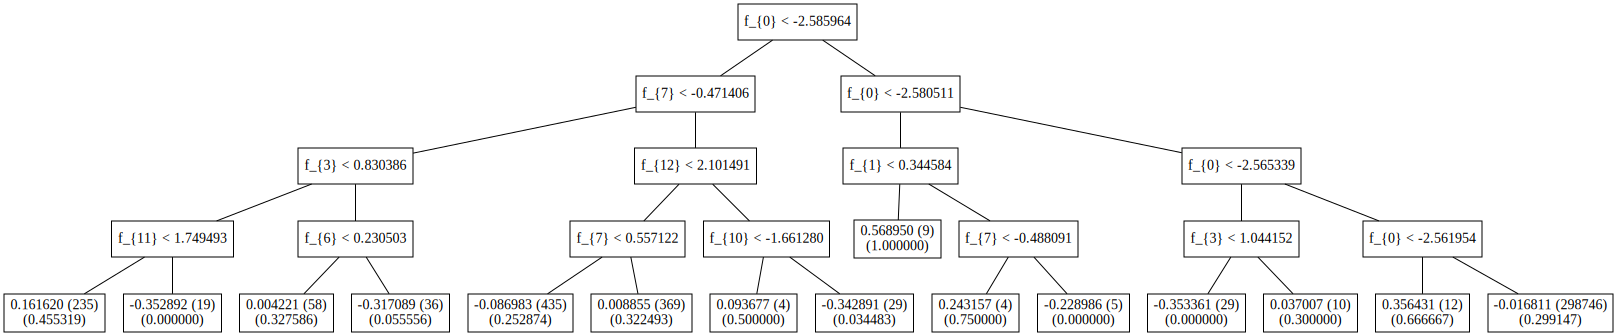

In [36]:
tree2gv(booster.forest[8][0])

In [37]:
dmat = xgb.DMatrix(features, label)

In [38]:
%%time
params = {'max_depth': 4, 'objective': 'binary:logistic', 'eta': 0.3, 'tree_method': 'exact', 'lambda': 1}
model = xgb.train(params, dmat, num_boost_round=20)

[01:09:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[01:09:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[01:09:08] /work

In [39]:
pred_fast = model.predict(dmat)
metrics.roc_auc_score(label[:, 0], pred_fast)

0.542374554521013

In [52]:
pred_fast = model.predict(dmat, ntree_limit=16)
metrics.roc_auc_score(label[:, 0], pred_fast)

0.5399173907210083

In [58]:
qq = -np.log(1/pred_fast-1) 
np.min(qq), np.max(qq)

(-1.5864264, 0.065994635)

In [60]:
diff = np.abs(qq - pred2b)
np.mean(diff > 0.1)

0.005003333333333334

In [39]:
model.dump_model('xgb.dump')

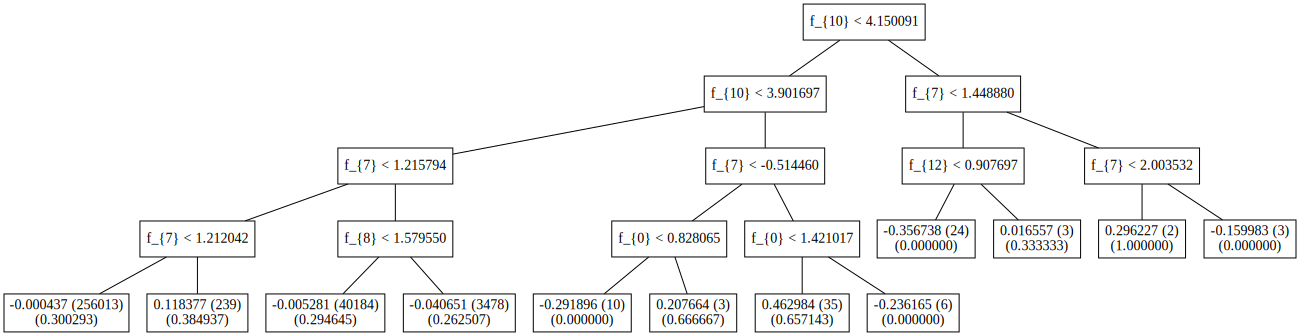

In [61]:
tree2gv(booster.forest[15][0])

In [47]:
!cat xgb.dump | tail -n+$(echo 32*11+22 | bc)

				23:leaf=0.071878612
				24:leaf=-0.118718132
			14:[f5<0.211397499] yes=25,no=26,missing=25
				25:leaf=0.343210191
				26:leaf=-0.216186628
booster[12]:
0:[f11<2.55600643] yes=1,no=2,missing=1
	1:[f8<-2.59899998] yes=3,no=4,missing=3
		3:[f12<-0.328634024] yes=7,no=8,missing=7
			7:[f12<-1.0331192] yes=15,no=16,missing=15
				15:leaf=0.0159282871
				16:leaf=0.189967081
			8:[f1<1.595752] yes=17,no=18,missing=17
				17:leaf=-0.0300083738
				18:leaf=0.258063436
		4:[f5<2.42508721] yes=9,no=10,missing=9
			9:[f6<-3.28118873] yes=19,no=20,missing=19
				19:leaf=-0.155871168
				20:leaf=-0.00355724571
			10:[f3<-1.20164371] yes=21,no=22,missing=21
				21:leaf=0.0608582459
				22:leaf=-0.0388015732
	2:[f1<0.0905285776] yes=5,no=6,missing=5
		5:[f2<-0.652622223] yes=11,no=12,missing=11
			11:[f2<-0.675517976] yes=23,no=24,missing=23
				23:leaf=0.058424186
				24:leaf=0.583348334
			12:[f4<1.31919718] yes=25,no=26,missing=25
				25:leaf=-0.00596017158
				26:leaf=-0.15163514
		6:[f9<1.